Freely adapted from ctapipe documentation 
https://cta-observatory.github.io/

<div align="center" style="font-size: 2rem">

<img heoght="300px" src="https://cta-observatory.github.io/ctapipe/_images/ctapipe_logo.png" alt="ctapipe"/>


<p style="text-align: left;">CTA event reconstruction</p>

<p style="text-align: left">January 2021, Thomas Vuillaume</p>

<p style="text-align: center"></p>

</div>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import ctapipe
print(ctapipe.__version__)

0.8.0


In [2]:
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 14

## Text

In [3]:
from ctapipe.visualization import CameraDisplay

## Images from raw camera data

In [4]:
from ctapipe.io import event_source, EventSeeker
from ctapipe.utils.datasets import get_dataset_path

input_url = get_dataset_path('gamma_test_large.simtel.gz')

allowed_tels = [1,2,3,4]
source = event_source(input_url, allowed_tels=allowed_tels, back_seekable=True)

In [5]:
# Let's see one particular event

seeker = EventSeeker(source)
event = seeker[11]

Seeking to event by looping through events... (potentially long process)


In [6]:
tel_id = list(event.r0.tels_with_data)[0] 
waveform = event.r1.tel[tel_id].waveform
print(waveform.shape)

(1855, 30)


A waveform is like a video, here of 30 images of 1855 pixels

<IPython.core.display.Javascript object>


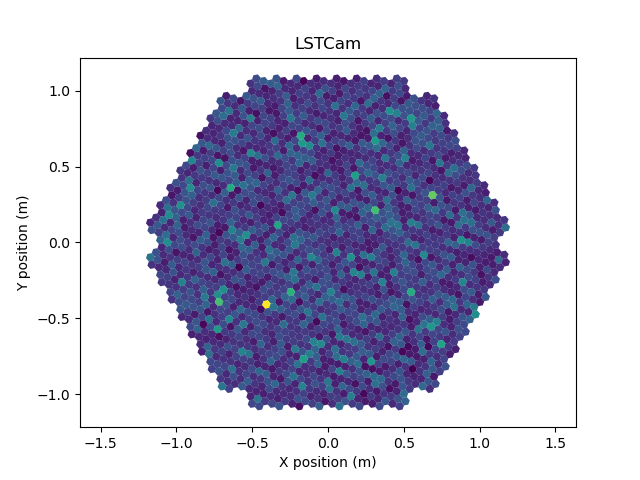

In [7]:
%matplotlib notebook

camera_geometry = source.subarray.tel[tel_id].camera.geometry

display = CameraDisplay(camera_geometry)

for image in waveform.T:
    display.image = image

Text(0, 0.5, 'ADC sum')

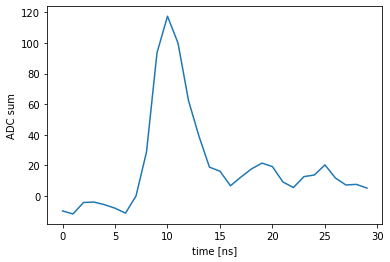

In [8]:
%matplotlib inline
plt.plot(waveform.sum(axis=0))
plt.xlabel('time [ns]')
plt.ylabel('ADC sum')

### Let's integrate these waveforms to produce images

In [9]:
from ctapipe.calib import CameraCalibrator

In [10]:
cal = CameraCalibrator(source.subarray)

In [11]:
cal(event)

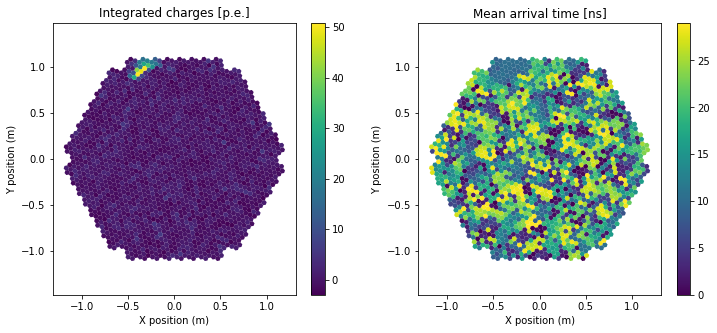

In [12]:
image = event.dl1.tel[tel_id].image
peak_time = event.dl1.tel[tel_id].peak_time

%matplotlib inline

fig, axes = plt.subplots(1, 2, figsize=(12,5))

disp = CameraDisplay(camera_geometry, image, ax=axes[0])
axes[0].set_title('Integrated charges [p.e.]')
disp.add_colorbar()

disp = CameraDisplay(camera_geometry, peak_time, ax=axes[1])
axes[1].set_title('Mean arrival time [ns]')
disp.add_colorbar()

From these, we can extract image features that are characteristic of the signal.

But first, we need to remove the noise.

### Image Cleaning

In [13]:
from ctapipe.image.cleaning import tailcuts_clean

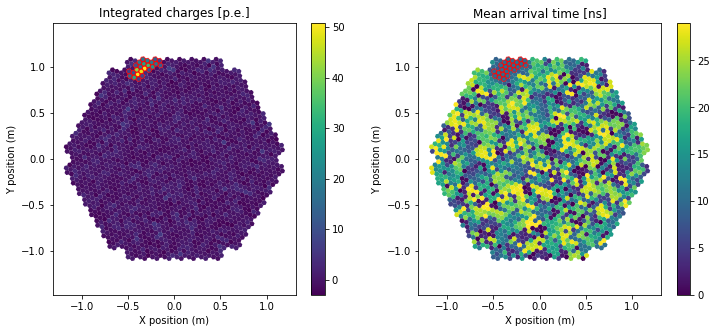

In [14]:
cleaning_mask = tailcuts_clean(camera_geometry, image)


fig, axes = plt.subplots(1, 2, figsize=(12,5))

disp = CameraDisplay(camera_geometry, image, ax=axes[0])
axes[0].set_title('Integrated charges [p.e.]')
disp.add_colorbar()
disp.highlight_pixels(cleaning_mask, color='red')


disp = CameraDisplay(camera_geometry, peak_time, ax=axes[1])
axes[1].set_title('Mean arrival time [ns]')
disp.add_colorbar()
disp.highlight_pixels(cleaning_mask, color='red')


### Image Parameters

In [15]:
from ctapipe.image import hillas_parameters, leakage, concentration
from ctapipe.image import timing_parameters
from ctapipe.image import number_of_islands
from ctapipe.image import camera_to_shower_coordinates

In [16]:
hillas = hillas_parameters(camera_geometry[cleaning_mask], image[cleaning_mask])

print(hillas)

{'intensity': 525.224063873291,
 'kurtosis': 2.275939969496951,
 'length': <Quantity 0.08935916 m>,
 'phi': <Angle 1.90226345 rad>,
 'psi': <Angle 0.55201841 rad>,
 'r': <Quantity 1.03943449 m>,
 'skewness': 0.18435539443343374,
 'width': <Quantity 0.03738116 m>,
 'x': <Quantity -0.33826383 m>,
 'y': <Quantity 0.98285382 m>}


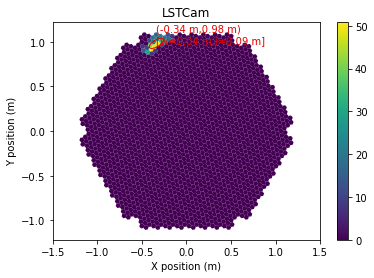

In [17]:
display = CameraDisplay(camera_geometry)

# set "unclean" pixels to 0
cleaned = image.copy()
cleaned[~cleaning_mask] = 0.0

display.image = cleaned
display.add_colorbar()

display.overlay_moments(hillas, color='xkcd:red')

Some other parameters than one can compute:
- number of islands after cleaning
- amount of signal on the camera border
- number of pixels with signal after cleaning
- gradient of the photons arrival time in pixels

... invent your own !

### Prediction on test dataset

- this is a simple demonstration of the event reconstruction principles and of a machine learning pipeline
- the training has been done previously on a larger dataset (not publicly available)
- the focus here is not on performances that can only be assessed on a dataset large enough

In [18]:
import os
import tables
from astropy.table import Table, vstack, join

In [19]:
dl1_path = 'data/dl1.h5'
if not os.path.exists(dl1_path):
    os.system(f'ctapipe-stage1-process --write-images True --write-parameters True --progress --input {input_url} --output {dl1_path} --allowed-tels=1,2,3,4')


In [20]:
os.stat(dl1_path) 

os.stat_result(st_mode=33188, st_ino=24911588, st_dev=12583067, st_nlink=1, st_uid=1000, st_gid=1000, st_size=1274638, st_atime=1611766123, st_mtime=1611766123, st_ctime=1611766976)

In [21]:
# reading parameters and images from the hdf5 file

with tables.open_file(dl1_path) as file:
    table_images = vstack([Table(file.root[f'/dl1/event/telescope/images/tel_00{i}'].read()) for i in allowed_tels])
    table_parameters = vstack([Table(file.root[f'/dl1/event/telescope/parameters/tel_00{i}'].read()) for i in allowed_tels])
    simu_parameters = Table(file.root.simulation.event.subarray.shower.read())
    
good_events = np.isfinite(table_parameters['hillas_intensity'])

table_parameters = table_parameters[good_events]
table_images = table_images[good_events]
table_parameters = join(table_parameters, simu_parameters, keys='event_id')

In [22]:
table_parameters

obs_id_1,event_id,tel_id,hillas_intensity,hillas_x,hillas_y,hillas_r,hillas_phi,hillas_length,hillas_width,hillas_psi,hillas_skewness,hillas_kurtosis,timing_slope,timing_slope_err,timing_intercept,timing_intercept_err,timing_deviation,leakage_pixels_width_1,leakage_pixels_width_2,leakage_intensity_width_1,leakage_intensity_width_2,concentration_cog,concentration_core,concentration_pixel,morphology_num_pixels,morphology_num_islands,morphology_num_small_islands,morphology_num_medium_islands,morphology_num_large_islands,intensity_max,intensity_min,intensity_mean,intensity_std,intensity_skewness,intensity_kurtosis,peak_time_max,peak_time_min,peak_time_mean,peak_time_std,peak_time_skewness,peak_time_kurtosis,obs_id_2,true_energy,true_alt,true_az,true_core_x,true_core_y,true_h_first_int,true_x_max,true_shower_primary_id
int32,int64,int16,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float64,float64,float64,int64,int64,int64,int64,int64,float32,float32,float32,float32,float64,float64,float32,float32,float32,float32,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,int64
7514,31012,3,23797.321395874023,-0.5763845246609662,0.7346220736267781,0.9337498119562624,128.117732977002,0.19430921825551656,0.07599419108081999,-75.7439816639251,1.4523057050873862,5.37752168764352,1.6696628048122708,0.12592917597909892,12.512913991248261,0.024469199803690965,0.5293196513275702,0.007547169811320755,0.016711590296495958,0.11476013,0.27465174,0.08740481559583761,0.5371192333290772,0.06262598481923919,236,2,0,1,1,1490.3307,5.0110655,100.836105,215.22592,3.706130027770996,15.407302856445312,14.93877,11.630609,12.941483,0.6978218,0.5438855886459351,-0.5634450912475586,7514,1.8637498617172241,68.47897801473843,6.384090732299001,51.67511749267578,69.65403747558594,18171.7265625,379.5384521484375,0
7514,31012,2,337.69730854034424,-1.013362778428503,0.34933688155949116,1.0718863640899838,160.97937448125776,0.17742714596988926,0.027583884442419403,60.827401031023165,-0.09290495790303172,1.9022368310789741,-3.5452692677918227,0.7728585989122961,11.260185206138356,0.13712609514098476,0.6323156360914693,0.00862533692722372,0.01293800539083558,0.7610274,0.9823656,0.15567785006647802,0.23637918769192406,0.10338064481453334,25,1,0,1,0,34.911366,5.9550962,13.507892,6.679499,1.435448408126831,2.086240768432617,13.292001,10.084342,11.218151,0.95960927,0.6687156558036804,-0.721707820892334,7514,1.8637498617172241,68.47897801473843,6.384090732299001,51.67511749267578,69.65403747558594,18171.7265625,379.5384521484375,0
7514,90914,4,101.23446798324585,0.3408595146854011,0.8960854285257873,0.9587253537733375,69.17382094930646,0.05108047952280709,0.020644495803588108,81.54089275122567,0.20628541158988115,2.098711032122164,-1.705712905947919,1.914888571021014,8.819012302608037,0.09781342578974904,0.3421749888944364,0.0,0.0,0.0,0.0,0.48288804566329857,0.3310448876139523,0.21896564044625674,8,1,0,1,0,22.16687,5.1583476,12.654308,5.7141156,0.10642874985933304,-1.283545970916748,9.266938,8.037775,8.722898,0.3215082,-0.5767676830291748,0.6230306625366211,7514,0.01654389686882496,70.67622938016402,3.107416974455515,-113.83343505859375,-142.3438720703125,15776.052734375,184.5454559326172,0
7514,153614,1,76.27321004867554,-0.4571816794098876,0.8517893900449554,0.9667265657781431,118.22382948921954,0.044144592018188294,0.0202851447764833,73.28638449166773,-0.3109469436211574,2.7668701561000115,-4.413752024226195,0.7844559462835529,8.729531581708246,0.03462948717421168,0.10225946027648876,0.0,0.0,0.0,0.0,0.6363746546991225,0.2749637299862403,0.2749637299862403,7,1,0,1,0,20.972366,5.3364415,10.896173,5.593333,0.6781468391418457,-0.9725890159606934,9.3223295,8.5160675,8.772883,0.25675833,1.1370081901550293,0.2657618522644043,7514,0.010249877348542213,68.949967369335,2.6661867540726916,-51.53120422363281,-106.75257873535156,19824.572265625,241.11111450195

In [23]:
table_parameters['log_intensity'] = np.log10(table_parameters['hillas_intensity'])
table_parameters['wl'] = table_parameters['hillas_width']/table_parameters['hillas_length']

In [24]:
import joblib
import json

Each task has its own model:
- disp is an intermediate to reconstruct the direction of the event in the sky
- the event energy
- the event type (gammaness ~ probability to be a gamma)


These models have been previously trained on a larger dataset using scikit-learn [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) and [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

In [25]:
disp_model_path = 'data/reg_disp_vector.sav'
energy_model_path = 'data/reg_energy.sav'
cls_model_path = 'data/cls_gh.sav'

disp_model = joblib.load(disp_model_path)
energy_model = joblib.load(energy_model_path)
cls_model = joblib.load(cls_model_path)

/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.23.2 when using vers

### Regression
We start with the regression of the direction and of the energy

In [26]:
# Features used during the training

features = ['log_intensity',
            'hillas_width',
            'hillas_length',
            'hillas_x',
            'hillas_y',
            'hillas_psi',
            'hillas_phi',
            'wl',
            'hillas_skewness',
            'hillas_kurtosis',
            'hillas_r',
            'timing_deviation',
            'leakage_intensity_width_2',
            'morphology_num_islands',
           ]

In [27]:
X = np.transpose([table_parameters[f].data for f in features])

In [28]:
X.shape

(46, 14)

In [29]:
disp_vector = disp_model.predict(X)

# the model is actually trained on the `log10(true_energy)` which acts as a normalization
log_energy = energy_model.predict(X)
energy = 10**log_energy

In [30]:
src_pos = table_parameters['hillas_x'] + disp_vector[:, 0], table_parameters['hillas_y'] + disp_vector[:, 1]
reco_parameters = Table(data=src_pos, names=['src_pos_x', 'src_pos_y'])
reco_parameters['energy'] = energy

In [31]:
reco_parameters

src_pos_x,src_pos_y,energy
float64,float64,float64
-0.6548875364917042,0.8548349590022142,0.19248467131450486
-0.8776801423407852,0.5171077990492495,0.04255905694351316
0.3456950588090962,0.9194826302518854,0.020839097329698825
-0.37338702646477373,0.9166065968388621,0.02482750343714517
-1.0491283276445682,0.057264948496333866,0.028140489311222896
-0.9305181386491004,0.32238472892079695,0.023201631724695353
-1.1187864275001784,0.1555971921956869,0.020510640347819832
0.785983832730303,-0.4594194777769439,0.022671905421457462
0.7726403943573305,-0.05001657670587326,0.0231794756532019


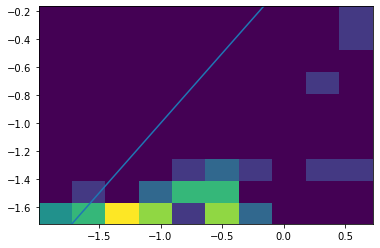

In [32]:
plt.hist2d(np.log10(table_parameters['true_energy']), np.log10(energy))
plt.plot([-2, 1], [-2, 1])

(I told you to not focus on performances here)

### Classification
The event classification uses the reconstructed parameters as input as well.   
This helps the classification task, increases the coherence across reconstructed parameters and can be viewed as a primitive multi-task approach

We simply concatenate the reconstructed values with the input vector:

In [33]:
print(X.shape)
print(disp_vector.shape, log_energy.shape)
X = np.concatenate([X, disp_vector, log_energy[:,None]], axis=1)
print(X.shape)

(46, 14)
(46, 2) (46,)
(46, 17)


In [34]:
reco_parameters['gammaness'] = cls_model.predict_proba(X)[:,1]
reco_parameters

src_pos_x,src_pos_y,energy,gammaness
float64,float64,float64,float64
-0.6548875364917042,0.8548349590022142,0.19248467131450486,0.9623641578219378
-0.8776801423407852,0.5171077990492495,0.04255905694351316,0.9733442143250326
0.3456950588090962,0.9194826302518854,0.020839097329698825,0.9844330529374008
-0.37338702646477373,0.9166065968388621,0.02482750343714517,0.9779330529374007
-1.0491283276445682,0.057264948496333866,0.028140489311222896,0.9858038073038072
-0.9305181386491004,0.32238472892079695,0.023201631724695353,0.9774245059288538
-1.1187864275001784,0.1555971921956869,0.020510640347819832,0.9811626011669489
0.785983832730303,-0.4594194777769439,0.022671905421457462,0.9854950187493665
0.7726403943573305,-0.05001657670587326,0.0231794756532019,0.9855418414918415


The threshold to categorize an event as gamma isusually determined per energy bin and function of the metric to optimize for the reconstruction (sensitivity, energy resolution, angular resolution... )    
For the example, we might set a threhsold at 0.99:

In [35]:
gammaness_cut = 0.98
reco_parameters['type'] = (reco_parameters['gammaness'] > gammaness_cut).astype(int)
reco_parameters

src_pos_x,src_pos_y,energy,gammaness,type
float64,float64,float64,float64,int64
-0.6548875364917042,0.8548349590022142,0.19248467131450486,0.9623641578219378,0
-0.8776801423407852,0.5171077990492495,0.04255905694351316,0.9733442143250326,0
0.3456950588090962,0.9194826302518854,0.020839097329698825,0.9844330529374008,1
-0.37338702646477373,0.9166065968388621,0.02482750343714517,0.9779330529374007,0
-1.0491283276445682,0.057264948496333866,0.028140489311222896,0.9858038073038072,1
-0.9305181386491004,0.32238472892079695,0.023201631724695353,0.9774245059288538,0
-1.1187864275001784,0.1555971921956869,0.020510640347819832,0.9811626011669489,1
0.785983832730303,-0.4594194777769439,0.022671905421457462,0.9854950187493665,1
0.7726403943573305,-0.05001657670587326,0.0231794756532019,0.9855418414918415,1


In this first part, we have seen on event parameters are traditionnaly reconstructed in Imaging Atmospheric Cherenkov Telescopes using random forests trained on hand-crafted image parameters.

In the second part, we will apply CNN to realise the same tasks but starting directly from the images.

----------


<!-- <div align="center" style="font-size: 6rem">
<p></p>
<p style="text-align: left;">Let's go deep</p> -->

# Now we will go deep

<img width="600px" src="https://nerdist.com/wp-content/uploads/2016/03/Fiding-nemo-Bruce-marlin.jpg" alt="ctapipe"/>
